# Determine redshift using machine learning

First, what is redshift and why is it important? Redshift is the equivalent to the distance of stellar objects from us. It is measured using spectroscopy. It calculates the shift of the spectra, which is a graph that shows how much light is emitted or absorbed at each wavelength,to the red side of the wavelength spectrum (hence the name redshift). The method used is to compare the spectra of the source to where the spectra should be at if the stellar objects were right next to us. They use emision lines of known elements to make hypothetical spectra of objects at redshift 0. Different types of objects have different shape of the spectra and objects within a class share similar characteristics. The stellar objects are shifted to the red because they are moving away from us due to the expansion of the universe. This measure is important because it allows us also to calculate the actual magnitudes of the stellar objects and we can do a lot of fun science with it. The amount of spectral data is not up to par with the vast amount of optical data available so it is important to have good redshifts obtained from photometry.

The data was obtained using the skyserver from the Sloan Digital Sky Survey (SDSS) using the SQL query. I did most of the data engineering in the query. I specified for no missing values of the redshift also for it to be positive (there are negative redshift which means they are moving towards us and that they are in our local area). I also made sure errors were between 0.0 and 0.1.For the five bands (u,g,r,i,z), I selected the dered values from the table to  account for galactic extinction. There may be a confusion between z the band and z the redshift but in this study the band will always be denoted with dered_z. I also contrained the errors on the magnitued to be less than 0.1. The SQL script used in the [CasJobs website](https://skyserver.sdss.org/casjobs/) can be seen in the file "sql_skyserver_sdss.odt" in the script_notebooks folder of this project.

To note that SDSS removed their photozRF table because it does poorly with the faint red galaxies targeted in  Baryon Oscillation Spectroscopic Survey (BOSS). 


In [86]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set()
%matplotlib inline

# Loading data and EDA

In [87]:
#loading files
filepath= "/home/veroastro/Documents/spectraTypes/MLphotometry/data/"
galaxy = pd.read_csv(filepath+"galaxy_rand5.csv")
star = pd.read_csv(filepath+"star_rand.csv")
QSO = pd.read_csv(filepath+"QSO_rand.csv")
extra_z = pd.read_csv(filepath+"highZ.csv")
print(f'Number of data points in the star dataframe {star["z"].count()}')
print(f'Number of data points in the OSO dataframe {QSO["z"].count()}')
print(f'Number of data points in the galaxy dataframe {galaxy["z"].count()}')

Number of data points in the star dataframe 3671
Number of data points in the OSO dataframe 5000
Number of data points in the galaxy dataframe 5000


The combined dataset will be imbalance towards stars. The SQL script is the same for all classes but for some reason the obtained star dataset is smaller than the QSO and galaxy datasets.

In [88]:
#Create the data frame from the three sets of data
data = pd.concat([star, QSO, galaxy])
#Scramble the data set so that it is not ordered by spectral class (QSO, galaxy or star) 
data = data.sample(frac=1)

data.shape

(13671, 19)

In [89]:
data_clean = data.drop(columns=['zWarning','objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr', 'class', 'subClass', 'photoZ','photoErr','type'])
data_clean.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
694,18.25106,17.60258,16.89922,16.32211,16.17514,0.120703
3824,17.83246,17.54208,17.21760,16.96313,16.95382,0.231123
247,19.52719,18.88762,18.11049,17.76713,17.33901,0.329972
134,19.53752,18.23403,17.23355,16.75252,16.46951,0.180853
2302,18.45884,17.22908,16.86094,16.69260,16.63852,0.033347


In [90]:
data_clean.describe()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
count,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,1.367100e+04
mean,19.123679,17.910556,17.236257,16.870452,16.628443,1.458658e-01
std,1.112383,1.220852,1.296912,1.318627,1.307353,2.567484e-01
min,6.673403,9.884518,9.321852,9.242759,9.800303,7.937708e-09
25%,18.571080,17.265860,16.477270,16.057380,15.791895,1.045076e-03
50%,19.270480,17.991810,17.242790,16.860720,16.611150,9.544864e-02
75%,19.871815,18.639680,18.055465,17.725690,17.495920,1.923601e-01
max,21.491850,20.960650,21.669820,20.886630,20.105530,6.215998e+00


In [91]:
def hist_plots( data: pd.DataFrame,
               rows: int,
              cols: int,
              figsize: tuple):
    fig, axes = plt.subplots(rows,cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(data.columns):
            data[(data.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{(data.columns)[i]} distribution', fontsize=10)
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.get_yaxis().get_label().set_visible(False)
            # Making it pretty with frame and grid
            ax.spines['top'].set_color('black')
            ax.spines['right'].set_color('black')
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['top'].set_linewidth(1)
            ax.spines['right'].set_linewidth(1)
            ax.spines['bottom'].set_linewidth(1)
            ax.spines['left'].set_linewidth(1)
            ax.grid(color='b', linestyle='-', linewidth=0.5)
            ax.set_facecolor('xkcd:white')
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

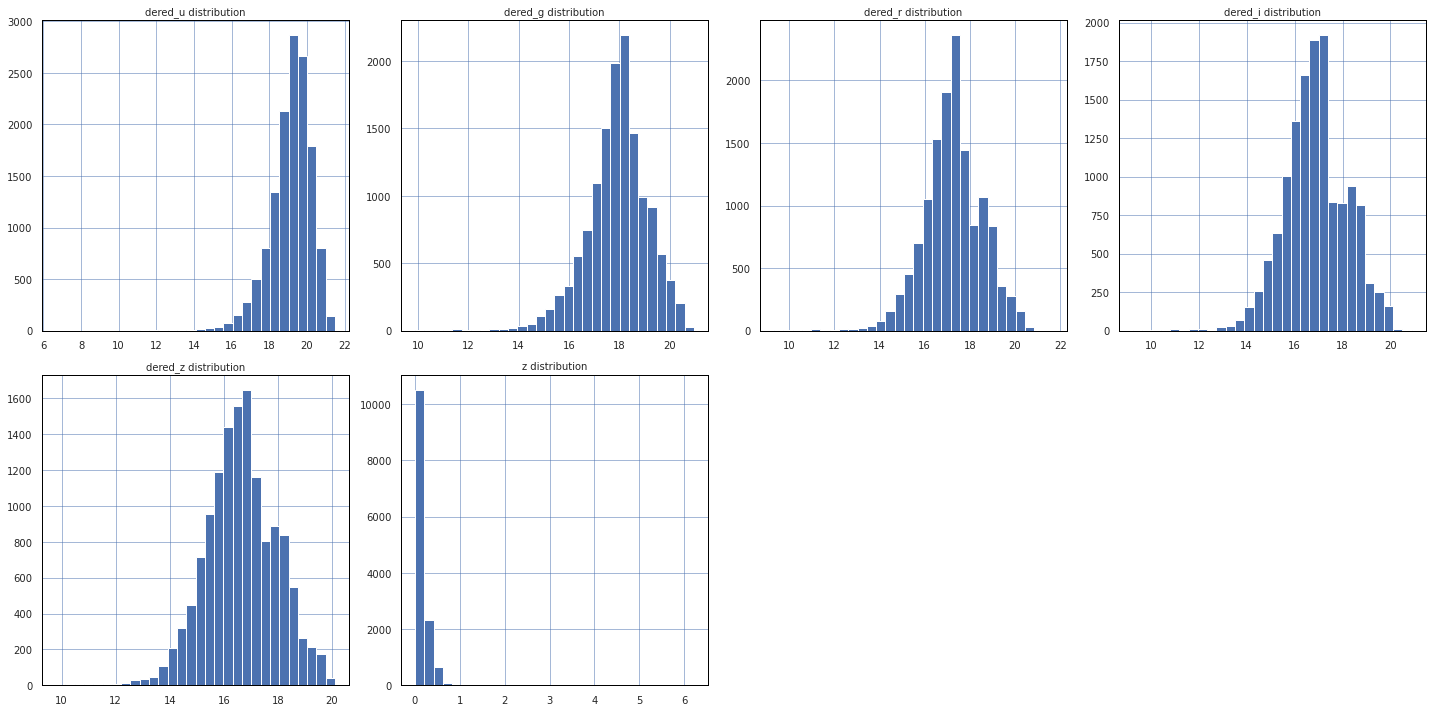

In [92]:
hist_plots(data=data_clean,
          rows=2,
          cols=4,
          figsize=(20,10))
#plt.savefig(filepath+'images/zhistplot.png')

The dered magnitudes follow roughly a normal distrubution with a tail towards brighter (lower values) magnitudes. There is also a small bumps on the right side of the distributions of the bands dered_r, dered_i and dered_z. 

## Looking at Redshifts

The columns of photoZ and photoErr refer to the redshift determined using only photometric(the magnitudes in the 5 SDSS bands) data. This was done using a kd-tree nearest neighbor fit (KF). There is more information on [photoZ page](https://www.sdss4.org/dr16/algorithms/photo-z/). The columns z and zERR refer to the spectroscopic redshifts obtained by comparing the spectra obtained with the assumed spectra at redshift 0. 

Text(0.5, 1.0, 'Redshif and PhotoZ Histograms')

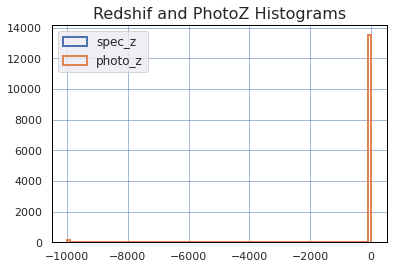

In [93]:
bins= 100
ax = plt.subplot(111)
ax.hist(data['z'] , bins,histtype='step', linewidth=2,label='spec_z')
ax.hist(data['photoZ'] , bins,histtype='step', linewidth=2, label='photo_z')
# Making it pretty with frame and grid
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.grid(color='b', linestyle='-', linewidth=0.5)
ax.set_facecolor('xkcd:white')
#set legend, lables and title
ax.legend(loc='upper left',fontsize=12)
#plt.set_xlabel(n)
ax.set_title('Redshif and PhotoZ Histograms', fontsize=16)

The distribution of the photometric redshift ranges from -10000 to positive numbers. In these cases, the photometric reshift werent able to determine the actual values of the redshift. The known values of redshift range from 0 up to around 11. But the vast majority of objects with known redshifts have values between 0 and 7.

Removing 165 objects with negative values of photoZ


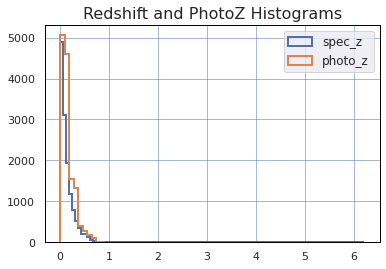

In [94]:
# Removing datapoints with negative values of photoZ
p_photoZ =data.loc[(data['photoZ'] >= 0.0)]['photoZ']
specZ = data['z']
p_specZ = data.loc[(data['photoZ'] >= 0.0)]['z']
print(f'Removing {specZ.count() - p_photoZ.count()} objects with negative values of photoZ' )
# Ploting the new distributions of photoZ and z
ax = plt.subplot(111)
#Plotting the two distributions of redshift
ax.hist(p_specZ , bins = 100,  histtype='step', linewidth=2,label='spec_z')
ax.hist(p_photoZ , histtype='step', linewidth=2, label='photo_z')
# Making it pretty with frame and grid
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.grid(color='b', linestyle='-', linewidth=0.5)
ax.set_facecolor('xkcd:white')
#set legend, lables and title
ax.legend(loc='upper right',fontsize=12)
#plt.set_xlabel(n)
ax.set_title('Redshift and PhotoZ Histograms', fontsize=16)
plt.show()

Both distributions are similar within the range of 0-0.8. The reason for choosing 2 different number of bins is that the  range of values in redshift differ from each other. The photometric redshift (eliminating negative values) ranges from 0-0.8 while the range of spectroscopic redshift is of 0 - 6 but the main area of the redshift is between 0- 0.8 with a long tail. This means that for these objects with redshift more than 0.8, the photometric redshift determines them with lower values of redshift. This means that we are sampling shorter redshift.

In [95]:
# Defining the photometric redshifht error for objects with positive fotometric redshifts
photozErr= data.loc[(data['photoZ'] >= 0.0)]['photoErr']
print('Mean photoError:', round(np.mean(photozErr), 5))

Mean photoError: 0.03713


In [96]:
# Defining the redshift error for objects with positive fotometric redshifts
speczErr= data.loc[(data['photoZ'] >= 0.0)]['zErr']
print('Mean specError:', round(np.mean(speczErr), 5))

Mean specError: 4e-05


The mean photometric redshift error is aproximately three orders of magnitudes larger then the mean values of spectroscopic redshift error.

## Sampling without photoZ values

In the histogram before, the values of the redshift sample mainly the population of objects with redshifts between 0-0.8. This bias may affect mostly galaxies and QSOs In this section, I check if by not constraining the data to have photoZ values if it also contrains the range of redshifts sampled. I use the same method and sql script as the original data but remove the values of photoZ and photoErr and with that also the inner join to the PhotoZ table.

In [97]:
new_galaxy = pd.read_csv(filepath+"galaxy_nophotoZ4.csv")
new_star = pd.read_csv(filepath+"star_nophotoZ.csv")
new_QSO = pd.read_csv(filepath+"QSO_nophotoZ.csv")

#Create the data frame from the three sets of data
data_nophoto = pd.concat([new_star, new_QSO, new_galaxy, extra_z])
#Scramble the data set so that it is not ordered by spectral class (QSO, galaxy or star) 
data_nophoto = data_nophoto.sample(frac=1)
data_nophoto.describe()

,objID,type,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,z,zErr,zWarning
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,2.000000e+04,20000.0
mean,1.237663e+18,5.195250,19.408312,0.043173,18.549213,0.010752,18.183921,0.011060,17.994293,0.012927,17.864113,0.036488,8.622533e-01,1.967128e-04,0.0
std,7.646793e+12,1.329179,1.031507,0.022679,1.276383,0.005642,1.455134,0.006727,1.529938,0.008521,1.575814,0.027468,9.377299e-01,3.277573e-04,0.0
min,1.237646e+18,3.000000,7.552934,0.003263,7.661058,0.000773,8.319589,0.000540,10.746470,0.000361,8.741409,0.001826,5.417808e-09,2.446185e-07,0.0
25%,1.237658e+18,3.000000,18.862427,0.025025,17.752275,0.006469,17.105070,0.005618,16.784280,0.005862,16.584933,0.012720,2.190941e-03,1.277849e-05,0.0
50%,1.237662e+18,6.000000,19.543140,0.039747,18.658460,0.009398,18.426430,0.009054,18.302120,0.010392,18.229885,0.028137,2.034847e-01,4.446151e-05,0.0
75%,1.237667e+18,6.000000,20.141998,0.058602,19.581840,0.014163,19.417122,0.015366,19.308055,0.018459,19.232980,0.056469,1.689518e+00,3.274784e-04,0.0
max,1.237681e+18,6.000000,21.578460,0.099982,22.145940,0.089225,21.324990,0.077705,21.340340,0.087281,20.616610,0.099985,6.429002e+00,2.278432e-02,0.0


In [98]:
print(f'Number of data points in the star dataframe {new_star["z"].count()}')
print(f'Number of data points in the OSO dataframe {new_QSO["z"].count()}')
print(f'Number of data points in the galaxy dataframe {new_galaxy["z"].count()}')

Number of data points in the star dataframe 5000
Number of data points in the OSO dataframe 5000
Number of data points in the galaxy dataframe 5000


Now the combine data set will be balance between the three classes. Maybe the discrepancy between the star datasets is because of the contraint on the photometric values. 

In [99]:
full_data = data_nophoto.drop_duplicates(keep='last').copy()
classes = extra_z['class'].unique()
classes

array(['QSO'], dtype=object)

In [100]:
# converting class from categorical to numerical
def type_to_value(n):
    if n == 'STAR':
        return 1
    elif n == 'QSO':
        return 2
    elif n == 'GALAXY':
        return 3
    

data['nClass'] = [type_to_value(n) for n in data['class']]
full_data['nClass'] = [type_to_value(n) for n in full_data['class']]

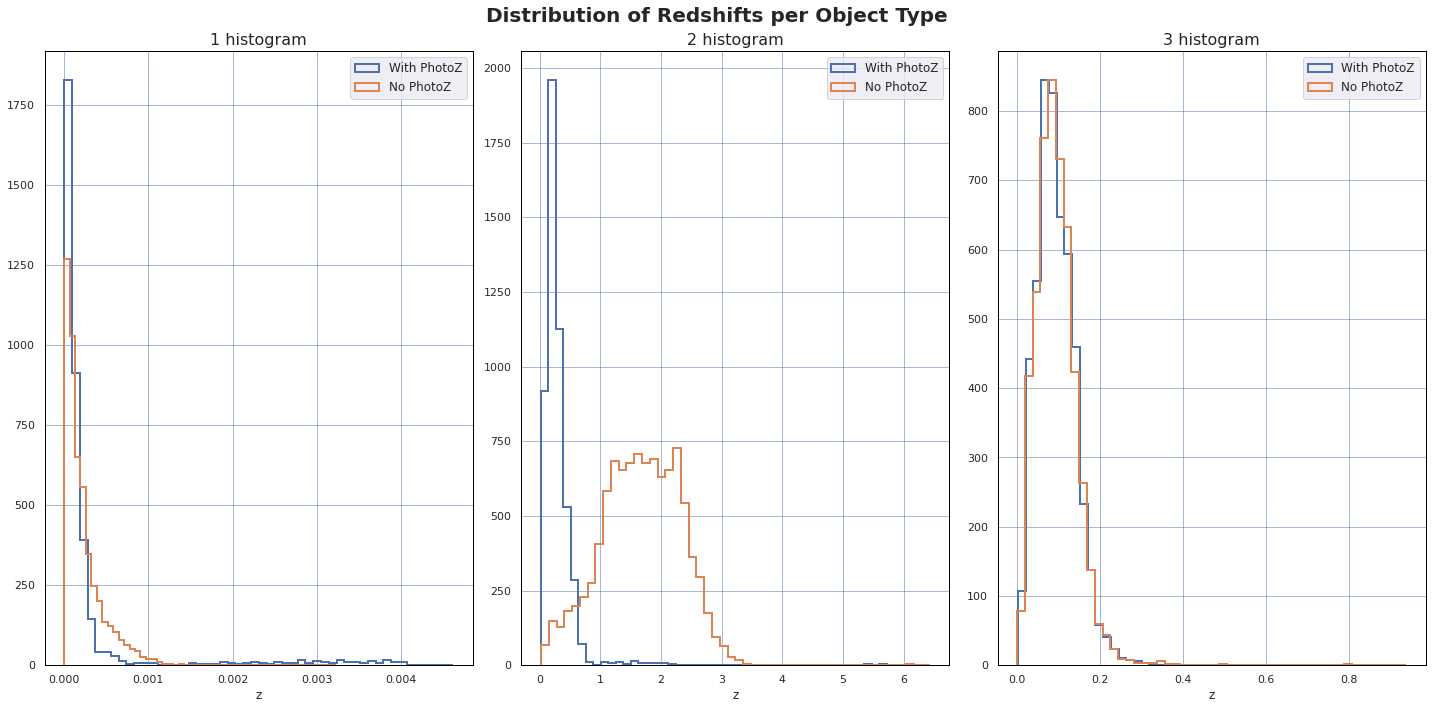

In [101]:
# Plotting the distributions of redshifts (z and photoZ) for each class (star, QSO, galaxy)
bins= 50

cols = [1, 2, 3]
fig,axs = plt.subplots(1,3, figsize=(20,10), edgecolor='black')
axs = axs.ravel()

for i, n in enumerate(cols):
    ax = axs[i]
    if i < len(cols):
        #create the histograms for the object type per band
        ax.hist(data[data['nClass']== n]['z'],bins= bins,histtype='step', linewidth=2,label='With PhotoZ')
        ax.hist(full_data[full_data['nClass']== n]['z'],bins= bins,histtype='step', linewidth=2, label='No PhotoZ')
        # Making it pretty with frame and grid
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        ax.grid(color='b', linestyle='-', linewidth=0.5)
        ax.set_facecolor('xkcd:white')
        #set legend, lables and title
        ax.legend(loc='upper right',fontsize=12)
        ax.set_xlabel('z')
        ax.set_title(f'{n} histogram', fontsize=16)
    else:
        fig.delaxes(ax=ax)
            
fig.suptitle('Distribution of Redshifts per Object Type', fontsize=20, fontweight="bold")
fig.tight_layout()
plt.show()

Both distributions of spectroscopic redshifts (z) for the datasets with and without photometric redshift contraint are very similar for the class 1(star) and class 3(galaxy). For the class2(QSO), both distributions are quite different. The distribution of photoZ has values mostly in the region between 0 and 1. While the distribution of z has values mostly between 0 and 3. 

Because of this and the fact that without the photoZ contraint the  dataset is balanced, I decided that for building the models to determine redshift I will use the dataset without photometric constraint.

## Prepping new dataset

In [102]:
data_cl = full_data.drop(columns=['zWarning','objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr', 'class', 'subClass','type'])
data_cl.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass
2093,20.03876,18.26189,17.30928,16.90302,16.55984,0.110211,3
1671,20.00170,18.27718,17.54545,17.08346,16.83391,0.052717,3
4743,19.58453,18.33141,17.90503,17.77609,17.73589,0.000218,1
2694,19.85048,18.09984,17.12465,16.71248,16.40944,0.108356,3
2773,19.40690,19.19275,19.10979,18.92676,18.91624,1.616285,2


## Looking at magnitudes and colours for the data_nophoto 

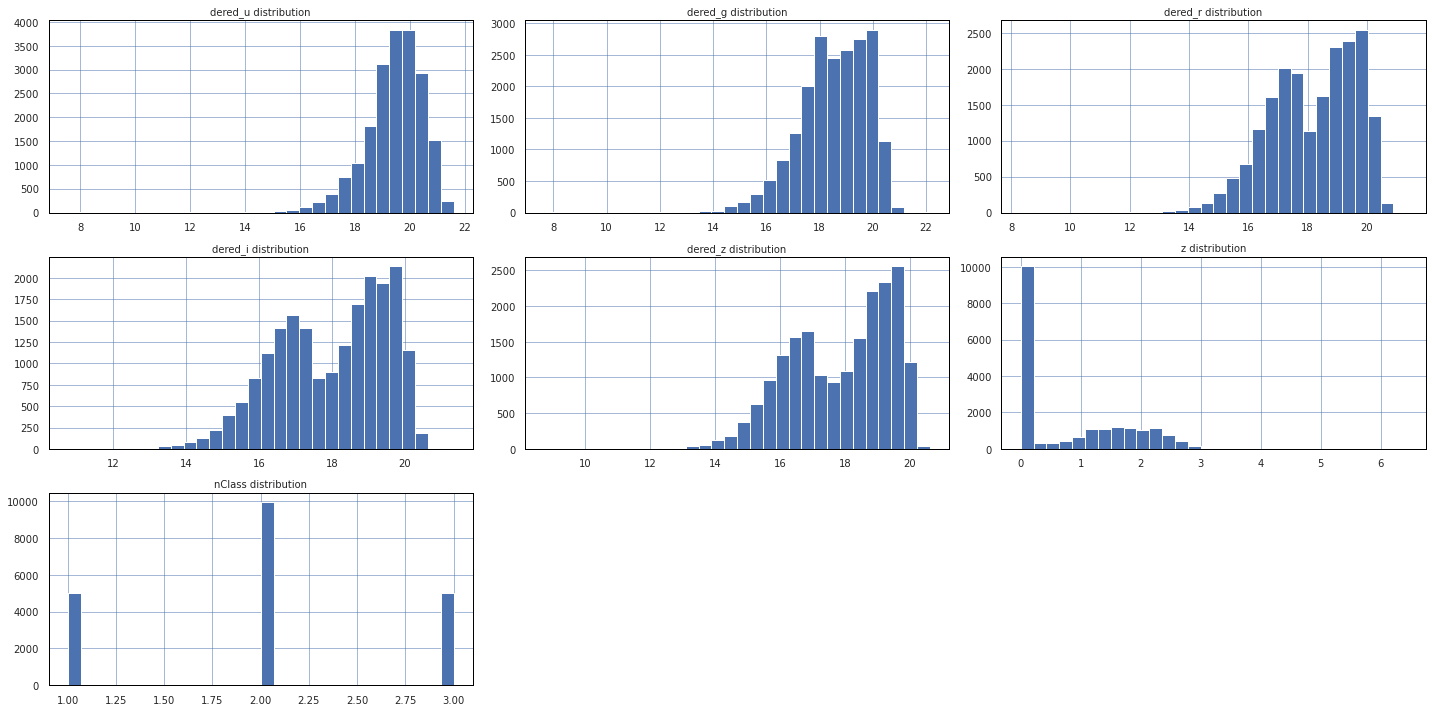

In [103]:
hist_plots(data=data_cl,
          rows=3,
          cols=3,
          figsize=(20,10))

The distribution of the magnitudes per band doesn't have a normal distribution like the distributions with photoZconstrains. This could be due to the fact that I am combining three different populations.

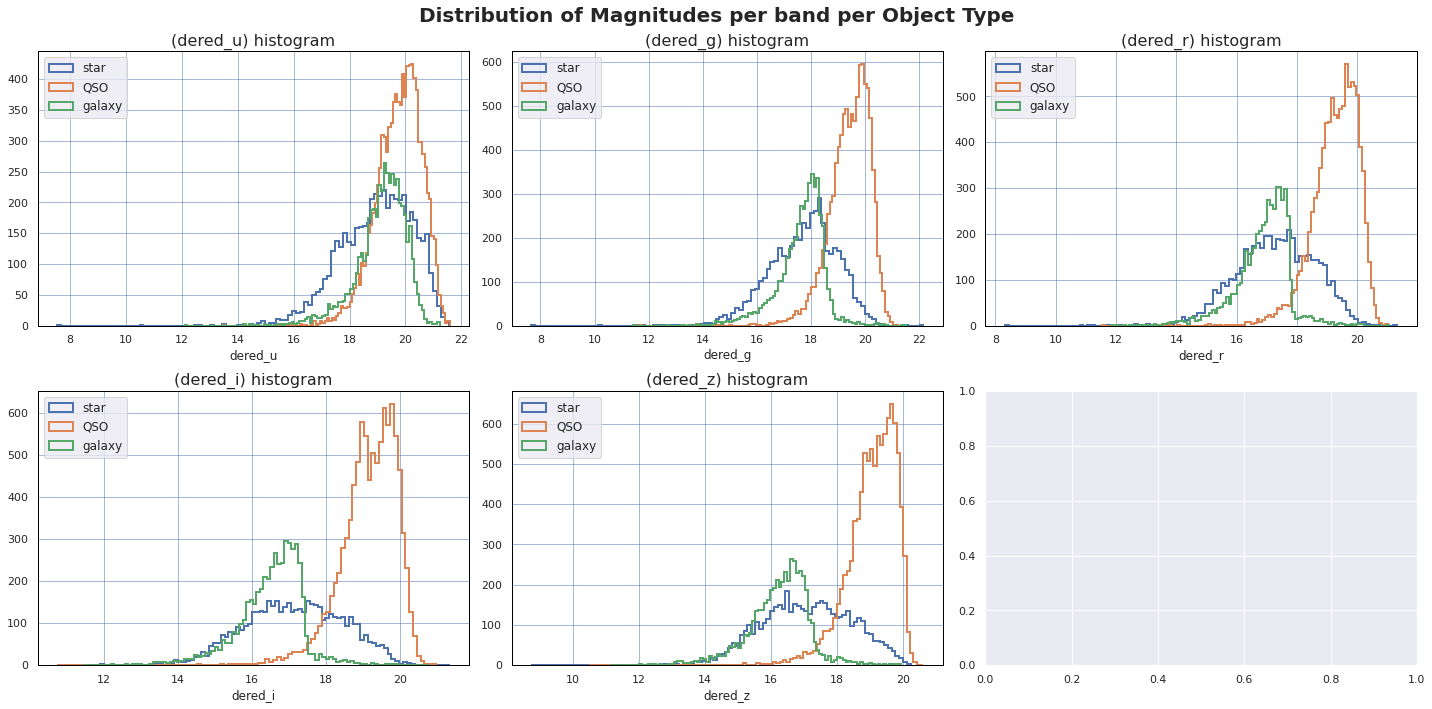

In [104]:
# Plotting the magnitudes per band per class
cols = ['dered_u','dered_g','dered_r','dered_i','dered_z']
bins= 100
# Create subplots and plot histograms
fig,axs = plt.subplots(2,3, figsize=(20,10), edgecolor='black')
axs = axs.ravel()
data.loc[(data['photoZ'] >= 0.0)]['photoErr']
for i, n in enumerate(cols):
    ax = axs[i]
    X = data_cl[n]
    if i < len(cols):
        #create the histograms for the object type per band
        ax.hist(X.loc[data_cl['nClass']==1], bins,histtype='step', linewidth=2,label='star')
        ax.hist(X.loc[data_cl['nClass']==2], bins,histtype='step', linewidth=2, label='QSO')
        ax.hist(X.loc[data_cl['nClass']==3], bins,histtype='step', linewidth=2, label='galaxy')
        # Making it pretty with frame and grid
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        ax.grid(color='b', linestyle='-', linewidth=0.5)
        ax.set_facecolor('xkcd:white')
        #set legend, lables and title
        ax.legend(loc='upper left',fontsize=12)
        ax.set_xlabel(n)
        ax.set_title(f'({n}) histogram', fontsize=16)
    else:
        fig.delaxes(ax=ax)
            
fig.suptitle('Distribution of Magnitudes per band per Object Type', fontsize=20, fontweight="bold")
fig.tight_layout()
plt.show()

The increasingly bimodal distribution of the magnitudes per band can be explained by the different populations in the dataset. I will use non-parametric learning algorithms to determine redshifts.

In [105]:
# Create a function to calculate the colours of the sources
def compute_colour(row):
    u = row['dered_u']
    g = row['dered_g']
    r = row['dered_r']
    i = row['dered_i']
    z = row['dered_z']
    return pd.Series({'u-g': u - g, 'g-r': g - r, 'r-i': r - i, 'i-z': i - z})
# Apply the function compute_colour
colour_ind = data_cl.apply(compute_colour, axis=1)
# Create new dataframe with the colours added
data_colour = pd.concat([data_cl,colour_ind], axis=1)
data_colour.describe()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass,u-g,g-r,r-i,i-z
count,19927.000000,19927.000000,19927.000000,19927.000000,19927.000000,1.992700e+04,19927.000000,19927.000000,19927.000000,19927.000000,19927.000000
mean,19.407376,18.546094,18.180051,17.990035,17.859543,8.590588e-01,2.000000,0.861282,0.366043,0.190016,0.130492
std,1.032306,1.276988,1.455812,1.530524,1.576298,9.374700e-01,0.708419,0.659448,0.339882,0.187343,0.169282
min,7.552934,7.661058,8.319589,10.746470,8.741409,5.417808e-09,1.000000,-1.512210,-1.709300,-3.861471,-1.146380
25%,18.860940,17.748730,17.101655,16.779930,16.579515,1.207272e-03,1.000000,0.254505,0.104440,0.066465,0.016445
50%,19.541950,18.652150,18.417720,18.290460,18.221180,1.936482e-01,2.000000,0.848880,0.284710,0.175490,0.118090
75%,20.141750,19.579060,19.415765,19.305960,19.231525,1.687586e+00,3.000000,1.339790,0.591615,0.333715,0.253705
max,21.578460,22.145940,21.324990,21.340340,20.616610,6.429002e+00,3.000000,3.653620,3.852890,1.688770,3.762850


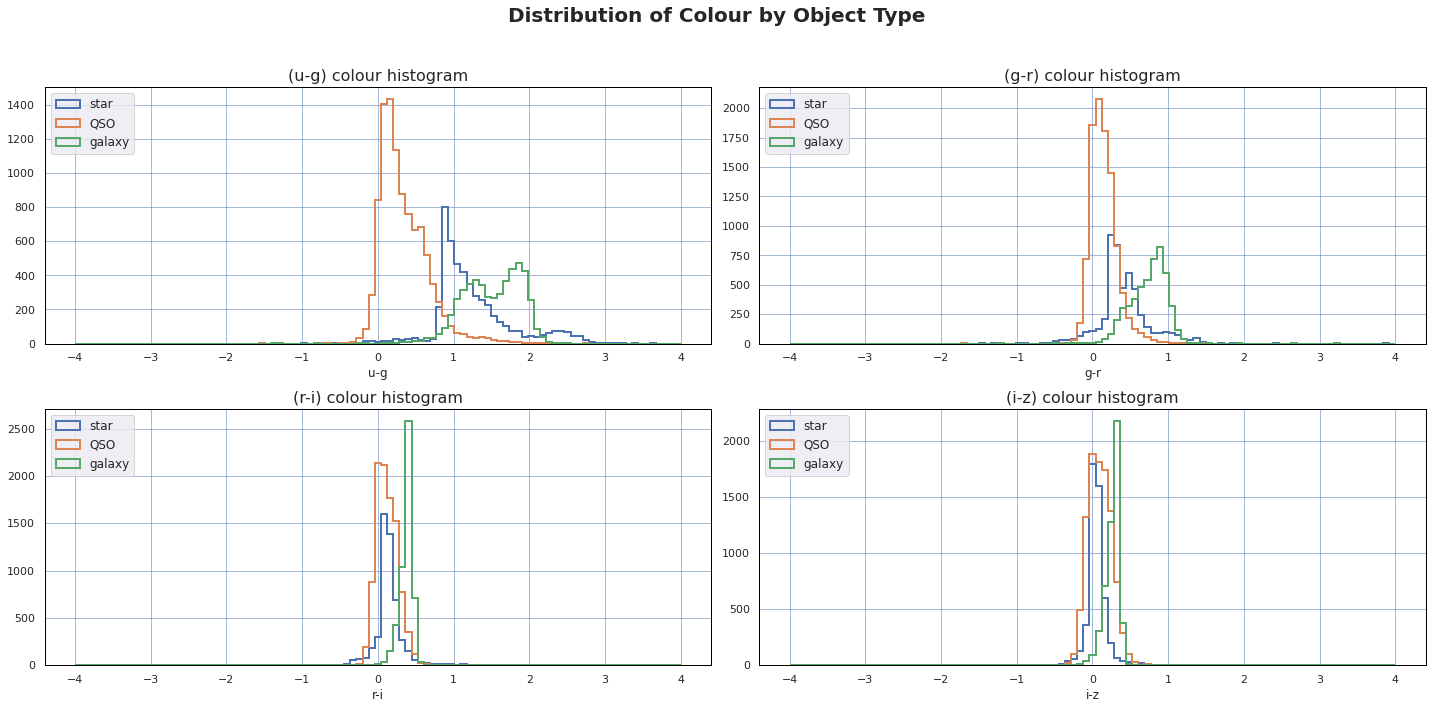

In [106]:
# Plotting colours per object type
colour = ['u-g','g-r','r-i','i-z']

# Create subplots and plot histograms
bins = np.linspace(-4, 4, 100)
fig,axs = plt.subplots(2,2, figsize=(20,10), edgecolor='black')
axs = axs.ravel()

for i, n in enumerate(colour):
    ax = axs[i]
    X = data_colour[n]
    #create the histograms for the object type per colour
    ax.hist(X.loc[data_colour['nClass']==1], bins,histtype='step', linewidth=2,label='star')
    ax.hist(X.loc[data_colour['nClass']==2], bins,histtype='step', linewidth=2, label='QSO')
    ax.hist(X.loc[data_colour['nClass']==3], bins,histtype='step', linewidth=2, label='galaxy')
    # Making it pretty with frame and grid
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.grid(color='b', linestyle='-', linewidth=0.5)
    ax.set_facecolor('xkcd:white')
    #set legend, lables and title
    ax.legend(loc='upper left',fontsize=12)
    ax.set_xlabel(n)
    ax.set_title(f'({n}) colour histogram', fontsize=16)
    
fig.suptitle('Distribution of Colour by Object Type', fontsize=20, fontweight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

For stars, in the (u-g) and (g-r) distributions, I was expecting to see a bimodality which would indicate the star is a hot blue star (to the left of the distribution) or a cold red star(to the right). But the distribution on our sample shows no bimodality and has a taile towards redder colours. The distribution of stars seems to be between the destributions of QSOs and galaxies for all colours. 

For QSOs, the (u-g) distribution peak is much bluer than that of stars and galaxies. It is as expected since what we see in QSOs are the active galactic nuclei(AGN, supermassive black holes) that outshine the stars of their host galaxies. The radiation peaks at the blue end of the spectrum. In the other colours, the distribution is also bluer than the galaxy distribution. 

For galaxies, there is a bimodal distribution in the (u-g) and the (g-r) distribution has a bump on the left side of the distribution. What we are seeing here is two populations; one population of young blue galaxies and the other of old red galaxies. On the other hand, the distributions of (r-i) and (i-z) show a very narrow distribution with a high peak. This could be due to the fact that we are sampling interstellar dust. Dust can absorb or scatter the light emitted by stars in a galaxy which makes the galaxy appear redder than it actually is. These distributions can be affected by the limited wavelength coverage of the bands.

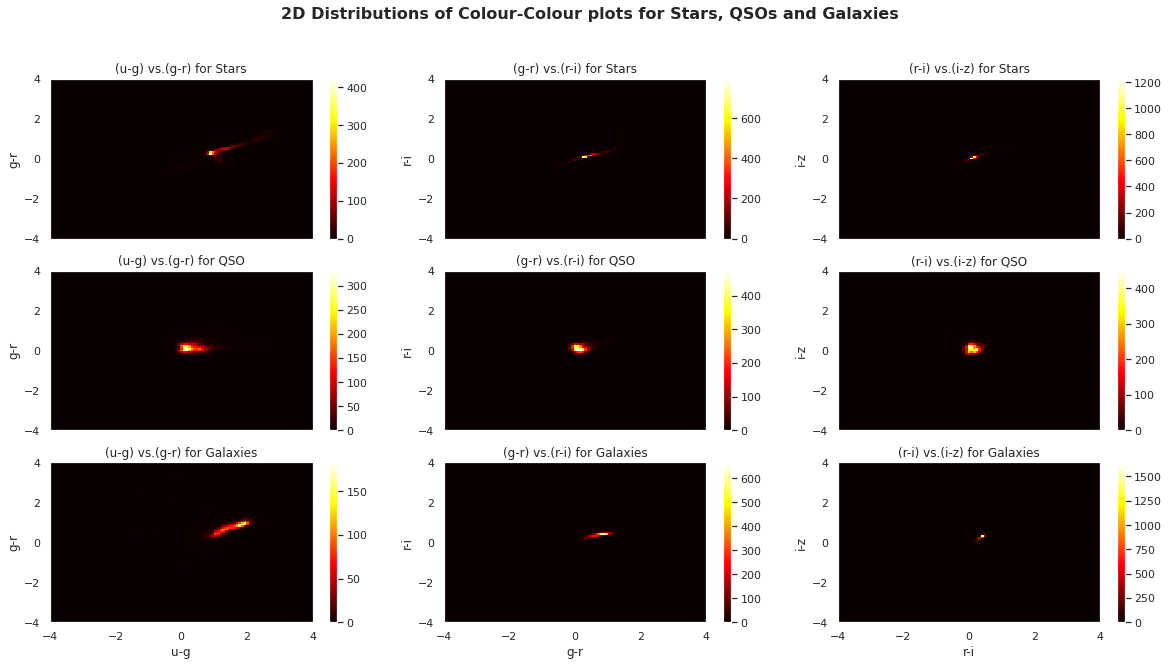

In [107]:
# Create 2D distributions for each colour vs colour for each object type
fig, axs = plt.subplots(3, 3, figsize=(20, 10), sharex='col')

bins = np.linspace(-4, 4, 100)

classes = [1, 2, 3]
objects = ['Stars', 'QSO', 'Galaxies']


for i in range(len(colour)-1):
    for j, n in enumerate(classes):
        
        h = axs[j, i].hist2d(data_colour.loc[data_colour['nClass']==n][colour[i]],
                         data_colour.loc[data_colour['nClass']==n][colour[i+1]], bins, cmap='hot')
        
        # Set labels for each subplot
        axs[j, i].set_title(f'({colour[i]}) vs.' f'({colour[i+1]}) for ' f'{objects[j]}')
        axs[j, i].set_ylabel(colour[i + 1])
        if j>= 2 :
                axs[j,i].set_xlabel(colour[i])
        
        # Add colorbars to each subplot
        fig.colorbar(h[3], ax=axs[j, i])    
            

fig.suptitle('2D Distributions of Colour-Colour plots for Stars, QSOs and Galaxies', 
             fontsize=16, fontweight="bold")

# Show the plot
plt.show()

Colour-colour plots are tools that help us in the study of the properties of astronomical objects and their evolution over time. In the case of stars, the (u-g) vs. (g-r) plot distinguishes between the hot, blue stars and the cold red stars. The position of a star in the plot depends on its temperature and the composition of its atmosphere, with hotter stars on the lower left side and colder stars on the upper right side. The (g-r) vs. (r-i) plot differentiates between stars of different temperatures and spectral types. The vertical axis (r-i) represents the star's metallicity, with metal-poor stars located towards the bottom and metal-rich stars towards the top. The (r-i) vs. (i-z) plot shows how stars of different colours and metallicities are affected by interstellar dust. Dust extinction causes reddening, which shifts colours to the red side of the spectrum. Stars with higher levels of dust extinction will be located on the upper right side. The plot can also reveal any possible relationships between dust extinction and the age or metallicity of stars.

In the case of QSOs, the (u-g) vs. (g-r) plot shows that most of the QSOs lie in a region with a tail that extends to the left and upper side (redder direction). This tail can be caused by two things: higher redshift (distance to the object) or that the spectra of these sources have emissions from the host galaxies too. This is more visible in the (g-r) vs. (r-i) plot where the plot is similar to that of the galaxies plot. The (r-i) vs. (i-z) plot shows a distribution that is very similar to that of galaxies, as we are primarily sampling the host galaxy radiation.

In the case of galaxies, the (u-g) vs. (g-r) plot shows a wide range that goes between the blue cloud (young, star-forming galaxies) in the left and down and the red sequence (older and more passive galaxies) in the right and upper side. In the (g-r) vs. (r-i) plot, the (g-r) colour is more sensitive to the age of the galaxy and the (r-i) is more sensitive to their metallicity. The (r-i) vs. (i-z) shows how galaxies are affected by interstellar dust.

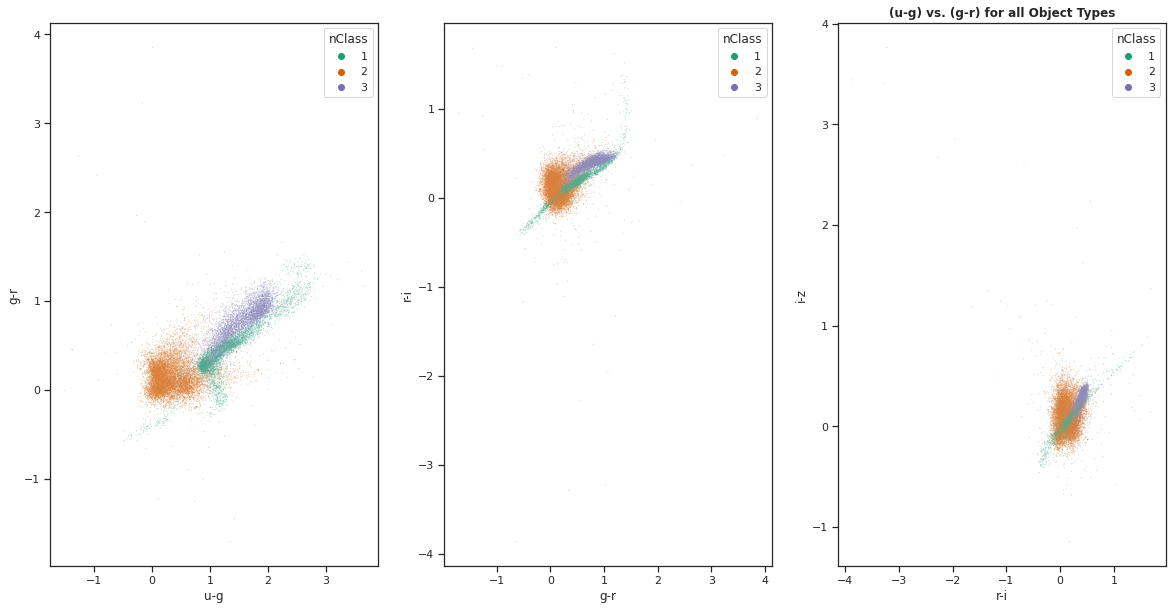

In [108]:
#Scatter plot hued by classes

sns.set_style("ticks")
  
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
sns.scatterplot(ax= axs[0], x="u-g", y="g-r", data= data_colour, hue='nClass', palette = 'Dark2',
             s = 1, alpha = 0.4)
sns.scatterplot(ax= axs[1], x="g-r", y="r-i", data= data_colour, hue='nClass', palette = 'Dark2',
             s = 1, alpha = 0.4)
sns.scatterplot(ax= axs[2], x="r-i", y="i-z", data= data_colour, hue='nClass', palette = 'Dark2',
             s = 1, alpha = 0.4)

# Add title and legend
plt.title('(u-g) vs. (g-r) for all Object Types', fontweight="bold")
#plt.legend( objects,fontsize=10, loc='upper left')
#plt.savefig('/home/veroastro/Documents/spectraTypes/images/scatter_classes.pdf')
plt.show()

The (u-g) vs (g-r) plot shows that the different classes occupy somewhat different regions of colour space.  Although there is the plenty intersection between them. In the other two plots the regions are less well defined. 

# Models and Analysis

In order to compare the results of our analysis, we use the dataset with the photometric redshift(photoZ). We calculate the mse of the photoZ with respect to the spectroscopic redshifht(z). It is important to note that this is done with different dataset from the one used to build the models. I do this because our dataset has a fainter (larger value of magnitudes) and the distribution of redshift also tends to higher values(more distant)then the dataset with photoZ. 

In [109]:
from sklearn.metrics import mean_squared_error

photozErr= data.loc[(data['photoZ'] >= 0.0)]['photoZ']
sZ= data.loc[(data['photoZ'] >= 0.0)]['z']
print('Mean Square Error PhotoZ:', round(mean_squared_error(sZ,photozErr), 3))

Mean Square Error PhotoZ: 0.054


The majority of the population on the dataset has a redshift less than 1. Because this might imbalance in the representation of the range of redshift available, I decided to do build the models and do the analysis on different subsets of the data. I divided the data into low with objects whose z is less or equal than 1 and high whith objects whose z is more than 1.

In [110]:
# Percentage of objects in each subset
print(f'Low Subset {round((data_cl.loc[(data_cl["z"] <= 1.0 )]["z"].count()/data_cl["z"].count()*100),2)} %')
print(f'High Subset {round((data_cl.loc[(data_cl["z"] > 1.0 )]["z"].count()/data_cl["z"].count()*100),2)} %')

Low Subset 57.33 %
High Subset 42.67 %


## Models

I use to learning algorithms to determine the redshifts: K-neighbor Regressor and Suppor Vector Regressor. 

### K-Nearest Neighbor Regressor(KNNR)
KNNR is a non-parametric algorithm that it doesn't make any assumptions about the underlying distribution of the data. Instead, it relies on the structure of the data itself to make predictions. It is a type of regression algorithm that uses the k nearest neighbors of a given data point to predict its value. In KNNR, the algorithm finds the k data points in the training set that are closest to the new data point being predicted, based on some distance metric, such as Euclidean distance. Then, the algorithm takes the average of the k closest data points as the predicted value for the new data point.

I use GridSearchCV to fine-tune the hyperparamethers of the algorithm. The parameters I set for fine-tuning are:
* n_neighbors which is the number of neighbors to use. In order to find the best range of the parameters, I run the algorithm specifying only this parameter and run it for a range of parameters. I then calculate the mse for each value on n_estimators and plot it against it. I select the range of values around the minimum.
* weights which means whether all points in each neighborhood are weighted equally or by the inverse of their distance.
* algorithm which is the algorithm used to compute nearest neighbors.
* leaf_size which is passed passed to BallTree or KDTree in the algorithm parameter.
* p which is the power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance, and euclidean_distance for p = 2.

### Support Vector Machine Regressor(SVR)
SVR works by finding a hyperplane that maximizes the margin between the predicted values and the actual values. The hyperplane is found by minimizing the sum of the distances between the predicted values and the actual values, subject to a constraint that the sum of the distances is less than or equal to a certain value, which is called the margin.

I again use GridSearchCV. The parameters I set for fine-tuning are:
* C which controls the tradeoff between fitting the training data and allowing for errors.
* gamma which controls the shape of the kernel function.
* kernel which is a function that takes two data points and outputs their similarity or "kernel" value. This kernel value is used to map the data points from their original input space to a higher dimensional feature space.

### Full Dataset
#### Data Selection and Preprocessing

In [111]:
from sklearn.preprocessing import RobustScaler
# separating feature X and label y and scaling data 
X = data_cl.drop(['nClass', 'z'], axis=1)
y = data_cl['z']
# Using RobustScaler to scale the dataset
scaler = RobustScaler()
X_t = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_t, columns = X.columns)

In [112]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {X_train["dered_u"].count()}')
print(f'Count of X_test = {X_test["dered_u"].count()}')

Count of X_train = 13948
Count of X_test = 5979


The test error of the linear regression model is (mse) 0.058 while we get an mse of 0.049 with random forest regressor. To compare errors the mse from the difference between photometric redshift and spectroscopic redshift is 0.068. Here there are values of photoz of -999.0. This are the same as missing values so they are taken out of the calculation of mse.

#### Model Contruction and Analysis KNN

In [113]:
from sklearn.neighbors import KNeighborsRegressor
# calculating the accuracy of models with different values of k
n= 20
mse = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(X_train,y_train)
    yhat= knn.predict(X_test)
    mse[i-1] = mean_squared_error(y_test, yhat)

mse

array([0.33101244, 0.27123939, 0.24787424, 0.2368246 , 0.23179398,
       0.23084899, 0.22994614, 0.23117509, 0.23152281, 0.23395687,
       0.23608829, 0.23618175, 0.23625875, 0.23874002, 0.24019507,
       0.24105349, 0.24237029, 0.24496877, 0.2457045 , 0.24676066])

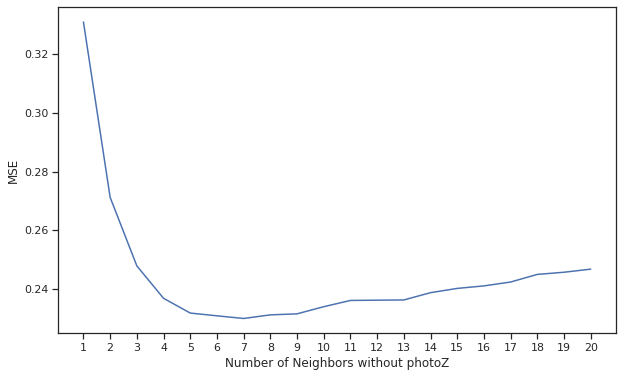

In [114]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse)
plt.xticks(loc)
plt.xlabel('Number of Neighbors without photoZ')
plt.ylabel('MSE')
plt.show()


In [115]:
from sklearn.model_selection import GridSearchCV
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [6,7,8],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR = knr.fit(X_train, y_train)

In [116]:
KNR.best_params_

{'algorithm': 'auto',
 'leaf_size': 1,
 'n_neighbors': 8,
 'p': 2,
 'weights': 'distance'}

In [117]:
# fit the model and predict the class
y_pred_knr = KNR.predict(X_test)

In [118]:
# Mean squared error
mse_KNR_all = mean_squared_error(y_test,y_pred_knr)
print('Mean Square Error KNN:', round(mse_KNR_all, 3))

Mean Square Error KNN: 0.222


#### Model Contruction and Analysis Support Vector Machine

In [33]:
from sklearn.svm import SVR
# Use the random grid to search for best hyperparameters
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'sigmoid']} 
#Setting the GridsherchCV 
SVR_grid = GridSearchCV(SVR(), param_grid,  n_jobs = -1) 
# fitting the model for grid search
svr = SVR_grid.fit(X_train, y_train)

# print best parameter after tuning 
svr.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [34]:
#predicting the values and calculating the mse
y_pred_SVR = svr.predict(X_test)
mse_SVR = mean_squared_error(y_test,y_pred_SVR)
print('Mean Square Error SVR:', round(mse_SVR, 3))

Mean Square Error SVR: 0.224


### Subset Low (z <= 1)
#### Data Selection and Preprocessing

In [119]:
# Subsetting the dataset by selecting from the full dataset only sources with z<=1
data_low = data_cl.loc[(data_cl['z'] <= 1.0 )]
data_low.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass
2093,20.03876,18.26189,17.30928,16.90302,16.55984,0.110211,3
1671,20.00170,18.27718,17.54545,17.08346,16.83391,0.052717,3
4743,19.58453,18.33141,17.90503,17.77609,17.73589,0.000218,1
2694,19.85048,18.09984,17.12465,16.71248,16.40944,0.108356,3
1290,21.22156,20.74939,20.37696,20.19884,19.99615,0.830226,2


In [120]:
# separating feature X and label y and scaling data 
X =data_low.drop(['nClass', 'z'], axis=1)
y = data_low['z']
# Using RobustScaler to scale the dataset
X_t_low = scaler.fit_transform(X)
X_scaled_low = pd.DataFrame(X_t_low, columns = X.columns)
# Split the data into training and test sets
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_scaled_low, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {Xl_train["dered_u"].count()}')
print(f'Count of X_test = {Xl_test["dered_u"].count()}')


Count of X_train = 7997
Count of X_test = 3428


#### Model Contruction and Analysis KNN

In [121]:
# Calculating the mse for a range of values to select the best range.
mse_low = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(Xl_train,yl_train)
    yhat= knn.predict(Xl_test)
    mse_low[i-1] = mean_squared_error(yl_test, yhat)

mse_low

array([0.00993251, 0.00842013, 0.00759503, 0.00745211, 0.00752136,
       0.00732415, 0.00755402, 0.0075545 , 0.00764505, 0.00782704,
       0.00786737, 0.00814663, 0.00822971, 0.00842114, 0.00847796,
       0.00852275, 0.00862679, 0.00869716, 0.00884201, 0.00893351])

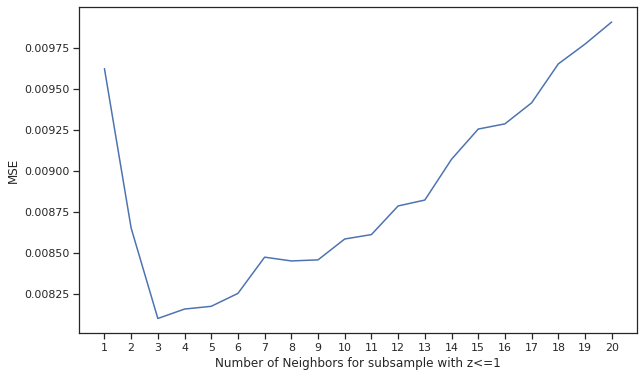

In [38]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_low)
plt.xticks(loc)
plt.xlabel('Number of Neighbors for subsample with z<=1')
plt.ylabel('MSE')
plt.show()


In [122]:
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [ 3, 4],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr_low = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_low = knr_low.fit(Xl_train, yl_train)

In [123]:
KNR_low.best_params_ 

{'algorithm': 'ball_tree',
 'leaf_size': 1,
 'n_neighbors': 4,
 'p': 2,
 'weights': 'distance'}

In [124]:
# fit the model and predict the class
yl_pred_knr = KNR_low.predict(Xl_test)

In [125]:
# Mean squared error
mse_KNR_low = mean_squared_error(yl_test,yl_pred_knr)
print('Mean Square Error KNN for z < 1 :', round(mse_KNR_low, 3))

Mean Square Error KNN for z < 1 : 0.007


#### Model Contruction and Analysis Support Vector Machine

In [44]:
# fitting the model for grid search
svr_low = SVR_grid.fit(Xl_train, yl_train)

# print best parameter after tuning 
svr_low.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [45]:
#predicting the values and calculating the mse
yl_pred_SVR = svr_low.predict(Xl_test)
mse_SVR_low = mean_squared_error(yl_test,yl_pred_SVR)
print('Mean Square Error SVR for z<=1:', round(mse_SVR_low, 3))

Mean Square Error SVR for z<=1: 0.009


### Subset high (z > 1)
#### Data Selection and Preprocessing

In [128]:
# Subsetting the dataset by selecting from the full dataset only sources with z<=1
data_high = data_cl.loc[(data_cl['z'] > 1.0 )]
data_high.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass
2773,19.40690,19.19275,19.10979,18.92676,18.91624,1.616285,2
1097,20.99212,20.04522,19.82113,19.77019,19.79399,2.732154,2
3098,20.03362,19.67803,19.72210,19.50118,19.34739,1.732659,2
2614,19.20903,18.96301,18.66391,18.76042,18.88937,1.100385,2
178,21.12817,20.49917,20.07659,19.85944,19.74935,1.432307,2


In [129]:
# separating feature X and label y and scaling data 
X = data_high.drop(['nClass', 'z'], axis=1)
y = data_high['z']
# Using RobustScaler to scale the dataset
X_t_high = scaler.fit_transform(X)
X_scaled_high = pd.DataFrame(X_t_high, columns = X.columns)
# Split the data into training and test sets
Xh_train, Xh_test, yh_train, yh_test = train_test_split(X_scaled_high, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {Xh_train["dered_u"].count()}')
print(f'Count of X_test = {Xh_test["dered_u"].count()}')


Count of X_train = 5951
Count of X_test = 2551


#### Model Contruction and Analysis KNN

In [130]:
# Calculating the mse for a range of values to select the best range.
mse_high = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(Xh_train,yh_train)
    yhat= knn.predict(Xh_test)
    mse_high[i-1] = mean_squared_error(yh_test, yhat)

mse_high

array([0.11423246, 0.09122281, 0.08415091, 0.08277644, 0.07841964,
       0.07813714, 0.07759268, 0.07744408, 0.07648013, 0.07731758,
       0.07663752, 0.07713662, 0.07743637, 0.07838913, 0.0788683 ,
       0.07890725, 0.07875681, 0.07935382, 0.07993862, 0.08066111])

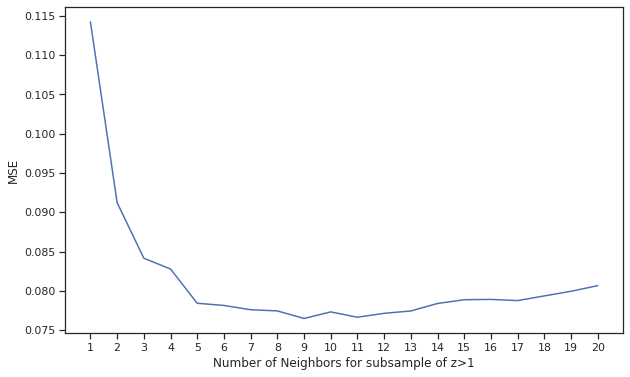

In [131]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_high)
plt.xticks(loc)
plt.xlabel('Number of Neighbors for subsample of z>1')
plt.ylabel('MSE')
plt.show()


In [132]:
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [9,10,11],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr_high = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_high = knr_high.fit(Xh_train, yh_train)

In [133]:
KNR_high.best_params_ 

{'algorithm': 'auto',
 'leaf_size': 3,
 'n_neighbors': 9,
 'p': 2,
 'weights': 'distance'}

In [134]:
# fit the model and predict the class
yh_pred_knr = KNR_high.predict(Xh_test)

In [135]:
# Mean squared error
mse_KNR_high = mean_squared_error(yh_test,yh_pred_knr)
print('Mean Square Error KNN for z > 1 :', round(mse_KNR_high, 3))

Mean Square Error KNN for z > 1 : 0.075


#### Model Contruction and Analysis Support Vector Machine

In [54]:
# fitting the model for grid search
svr_high = SVR_grid.fit(Xh_train, yh_train)

# print best parameter after tuning and best accuracy
svr_high.best_params_, svr_high.best_score_

({'C': 10, 'gamma': 1, 'kernel': 'rbf'}, 0.7455955806373981)

In [55]:
#predicting the values and calculating the mse
yh_pred_SVR = svr_high.predict(Xh_test)
mse_SVR_high = mean_squared_error(yh_test,yh_pred_SVR)
print('Mean Square Error SVR:', round(mse_SVR_high, 3))

Mean Square Error SVR: 0.092


### All results together

In [56]:
from tabulate import tabulate
#create data
tab_data = [["All", round(mse_KNR_all, 3), round(mse_SVR, 3)], 
        ["Low",  round(mse_KNR_low, 3),  round(mse_SVR_low, 3)], 
        ["High",  round(mse_KNR_high, 3),  round(mse_SVR_high, 3)]]
  
#define header names
col_names = ["Dataset","MSE KNR", "MSE SVR"]
  
#display table
print(tabulate(tab_data, headers=col_names))


Dataset      MSE KNR    MSE SVR
---------  ---------  ---------
All            0.186      0.224
Low            0.008      0.009
High           0.099      0.092


## Adding Colours
### Full Dataset
#### Data Selection and Preprocessing

In [65]:
# separating feature X and label y and scaling data 
X = data_colour.drop(['nClass', 'z'], axis=1)
y = data_colour['z']
# Using RobustScaler to scale the dataset
X_t_c = scaler.fit_transform(X)
X_scaled_c = pd.DataFrame(X_t_c, columns = X.columns)


In [66]:
# Split the data into training and test sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled_c, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {X_train_c["dered_u"].count()}')
print(f'Count of X_test = {X_test_c["dered_u"].count()}')

Count of X_train = 10500
Count of X_test = 4500


The test error of the linear regression model is (mse) 0.058 while we get an mse of 0.049 with random forest regressor. To compare errors the mse from the difference between photometric redshift and spectroscopic redshift is 0.068. Here there are values of photoz of -999.0. This are the same as missing values so they are taken out of the calculation of mse.

#### Model Contruction and Analysis KNN

In [67]:
# calculating the accuracy of models with different values of k
n= 20
mse_c = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(X_train_c,y_train_c)
    yhat= knn.predict(X_test_c)
    mse_c[i-1] = mean_squared_error(y_test_c, yhat)

mse_c

array([0.2480735 , 0.18734867, 0.17128542, 0.1657061 , 0.15951012,
       0.15675774, 0.15490529, 0.15495787, 0.15648945, 0.15573004,
       0.15591711, 0.15703937, 0.1575419 , 0.15802461, 0.15734009,
       0.15805359, 0.15917229, 0.15999275, 0.16045963, 0.16148942])

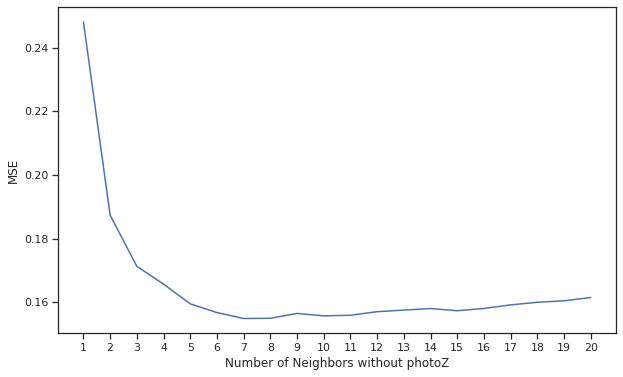

In [68]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_c)
plt.xticks(loc)
plt.xlabel('Number of Neighbors without photoZ')
plt.ylabel('MSE')
plt.show()


In [69]:
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [6,7,8],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr_c = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_c = knr_c.fit(X_train_c, y_train_c)

In [70]:
KNR_c.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 2,
 'n_neighbors': 8,
 'p': 2,
 'weights': 'distance'}

In [72]:
# fit the model and predict the class
y_pred_knr_c = KNR_c.predict(X_test_c)

In [73]:
# Mean squared error
mse_KNR_all_c = mean_squared_error(y_test_c,y_pred_knr_c)
print('Mean Square Error KNN:', round(mse_KNR_all_c, 3))

Mean Square Error KNN: 0.149


#### Model Contruction and Analysis Support Vector Machine

In [74]:
# fitting the model for grid search
svr_c = SVR_grid.fit(X_train_c, y_train_c)

# print best parameter after tuning 
svr_c.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [75]:
#predicting the values and calculating the mse
y_pred_SVR_c = svr_c.predict(X_test_c)
mse_SVR_c = mean_squared_error(y_test_c,y_pred_SVR_c)
print('Mean Square Error SVR:', round(mse_SVR_c, 3))

Mean Square Error SVR: 0.155


### Subset Low (z <= 1)
#### Data Selection and Preprocessing

In [76]:
# Subsetting the dataset by selecting from the full dataset only sources with z<=1
data_low_c = data_colour.loc[(data_colour['z'] <= 1.0 )]
data_low_c.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass,u-g,g-r,r-i,i-z
4703,17.88066,17.02852,16.75267,16.66802,16.64030,0.000108,1,0.85214,0.27585,0.08465,0.02772
2612,17.59278,15.86288,15.12480,14.75860,14.48882,0.026023,3,1.72990,0.73808,0.36620,0.26978
1567,17.44728,16.63208,16.39014,16.30775,16.29500,0.000111,1,0.81520,0.24194,0.08239,0.01275
2372,18.73686,16.75556,15.92954,15.58658,15.29613,0.052454,3,1.98130,0.82602,0.34296,0.29045
217,19.94895,19.59518,19.25947,19.32337,19.24062,0.983239,2,0.35377,0.33571,-0.06390,0.08275


In [78]:
# separating feature X and label y and scaling data 
X =data_low_c.drop(['nClass', 'z'], axis=1)
y = data_low_c['z']
# Using RobustScaler to scale the dataset
X_t_low_c = scaler.fit_transform(X)
X_scaled_low_c= pd.DataFrame(X_t_low_c, columns = X.columns)
# Split the data into training and test sets
Xl_train_c, Xl_test_c, yl_train_c, yl_test_c = train_test_split(X_scaled_low_c, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {Xl_train_c["dered_u"].count()}')
print(f'Count of X_test = {Xl_test_c["dered_u"].count()}')


Count of X_train = 7997
Count of X_test = 3428


#### Model Contruction and Analysis KNN

In [108]:
# Calculating the mse for a range of values to select the best range.
n=20
mse_low_c= np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(Xl_train_c,yl_train_c)
    yhat= knn.predict(Xl_test_c)
    mse_low_c[i-1] = mean_squared_error(yl_test_c, yhat)

mse_low_c

array([0.00657839, 0.00497469, 0.00472394, 0.00449551, 0.0045414 ,
       0.00445367, 0.00462271, 0.00463624, 0.00474026, 0.00482474,
       0.00491564, 0.00507051, 0.00517243, 0.00526146, 0.00532127,
       0.00537336, 0.00541215, 0.00543038, 0.00543364, 0.0054914 ])

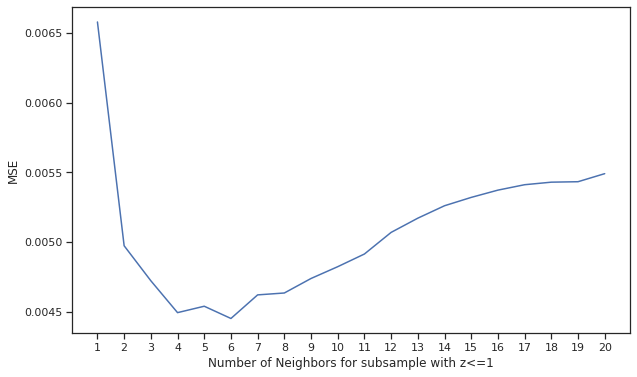

In [109]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_low_c)
plt.xticks(loc)
plt.xlabel('Number of Neighbors for subsample with z<=1')
plt.ylabel('MSE')
plt.show()


In [110]:
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [4,5,6],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr_low_c = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_low_c = knr_low_c.fit(Xl_train_c, yl_train_c)

In [111]:
KNR_low_c.best_params_ 

{'algorithm': 'ball_tree',
 'leaf_size': 1,
 'n_neighbors': 6,
 'p': 2,
 'weights': 'distance'}

In [112]:
# fit the model and predict the class
yl_pred_knr_c = KNR_low_c.predict(Xl_test_c)

In [113]:
# Mean squared error
mse_KNR_low_c = mean_squared_error(yl_test_c,yl_pred_knr_c)
print('Mean Square Error KNN for z < 1 :', round(mse_KNR_low_c, 3))

Mean Square Error KNN for z < 1 : 0.004


#### Model Contruction and Analysis Support Vector Machine

In [85]:
# fitting the model for grid search
svr_low_c = SVR_grid.fit(Xl_train_c, yl_train_c)

# print best parameter after tuning 
svr_low_c.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [86]:
#predicting the values and calculating the mse
yl_pred_SVR_c = svr_low_c.predict(Xl_test_c)
mse_SVR_low_c = mean_squared_error(yl_test_c,yl_pred_SVR_c)
print('Mean Square Error SVR for z<=1:', round(mse_SVR_low_c, 3))

Mean Square Error SVR for z<=1: 0.007


### Subset high (z > 1)
#### Data Selection and Preprocessing

In [87]:
# Subsetting the dataset by selecting from the full dataset only sources with z<=1
data_high_c = data_colour.loc[(data_colour['z'] > 1.0 )]
data_high_c.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass,u-g,g-r,r-i,i-z
1164,19.63107,19.11511,18.91133,18.63013,18.64311,1.618037,2,0.51596,0.20378,0.28120,-0.01298
1182,18.99975,18.66811,18.50714,18.50478,18.52532,1.251942,2,0.33164,0.16097,0.00236,-0.02054
1552,19.13222,19.12999,19.23925,19.07789,18.94833,1.715456,2,0.00223,-0.10926,0.16136,0.12956
1607,19.08581,18.88214,18.79280,18.89849,19.06236,1.179185,2,0.20367,0.08934,-0.10569,-0.16387
3318,19.30361,18.70311,18.62150,18.62959,18.41046,2.452712,2,0.60050,0.08161,-0.00809,0.21913


In [89]:
# separating feature X and label y and scaling data 
X = data_high_c.drop(['nClass', 'z'], axis=1)
y = data_high_c['z']
# Using RobustScaler to scale the dataset
X_t_high_c = scaler.fit_transform(X)
X_scaled_high_c = pd.DataFrame(X_t_high_c, columns = X.columns)
# Split the data into training and test sets
Xh_train_c, Xh_test_c, yh_train_c, yh_test_c = train_test_split(X_scaled_high_c, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {Xh_train_c["dered_u"].count()}')
print(f'Count of X_test = {Xh_test_c["dered_u"].count()}')


Count of X_train = 2502
Count of X_test = 1073


#### Model Contruction and Analysis KNN

In [96]:
# Calculating the mse for a range of values to select the best range.
n=50
mse_high_c = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(Xh_train_c,yh_train_c)
    yhat= knn.predict(Xh_test_c)
    mse_high_c[i-1] = mean_squared_error(yh_test_c, yhat)

mse_high_c

array([0.11847091, 0.10029376, 0.09285314, 0.09145092, 0.08760364,
       0.0831165 , 0.08098411, 0.08206198, 0.08241182, 0.08231578,
       0.08118999, 0.08187082, 0.08210724, 0.08186781, 0.08171106,
       0.0828204 , 0.0825626 , 0.08272702, 0.08243665, 0.08209679,
       0.08254651, 0.08246623, 0.08319136, 0.0830569 , 0.08344603,
       0.08331826, 0.08330116, 0.0831045 , 0.08308762, 0.08319161,
       0.08288249, 0.08290918, 0.08316996, 0.08318992, 0.08309899,
       0.08314482, 0.08311891, 0.08325974, 0.08335958, 0.08335874,
       0.0834342 , 0.08357939, 0.08414833, 0.08439377, 0.08457912,
       0.08453376, 0.08466656, 0.0850035 , 0.08527831, 0.08523023])

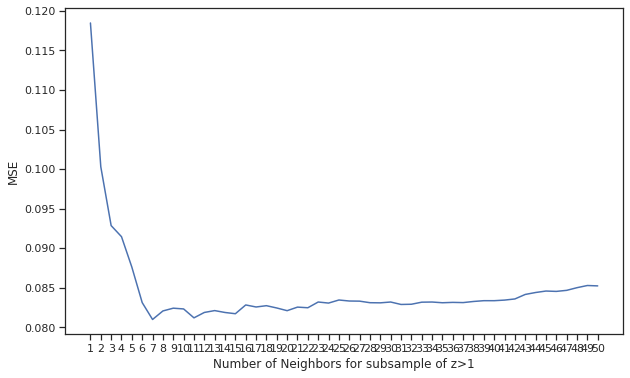

In [97]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_high_c)
plt.xticks(loc)
plt.xlabel('Number of Neighbors for subsample of z>1')
plt.ylabel('MSE')
plt.show()


In [98]:
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [6, 7, 11],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr_high_c = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_high_c = knr_high.fit(Xh_train_c, yh_train_c)

In [99]:
KNR_high_c.best_params_ 

{'algorithm': 'auto',
 'leaf_size': 4,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'distance'}

In [100]:
# fit the model and predict the class
yh_pred_knr_c = KNR_high_c.predict(Xh_test_c)

In [101]:
# Mean squared error
mse_KNR_high_c = mean_squared_error(yh_test_c,yh_pred_knr_c)
print('Mean Square Error KNN for z > 1 :', round(mse_KNR_high_c, 3))

Mean Square Error KNN for z > 1 : 0.081


#### Model Contruction and Analysis Support Vector Machine

In [102]:
# fitting the model for grid search
svr_high_c = SVR_grid.fit(Xh_train_c, yh_train_c)

# print best parameter after tuning 
svr_high_c.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [104]:
#predicting the values and calculating the mse
yh_pred_SVR_c = svr_high_c.predict(Xh_test_c)
mse_SVR_high_c = mean_squared_error(yh_test_c,yh_pred_SVR_c)
print('Mean Square Error SVR:', round(mse_SVR_high_c, 3))

Mean Square Error SVR: 0.08


### All results together of Coloured data

In [121]:
#create data
tab_data_c = [["All", round(mse_KNR_all_c, 3), round(mse_SVR_c, 3)], 
        ["Low",  round(mse_KNR_low_c, 3),  round(mse_SVR_low_c, 3)], 
        ["High",  round(mse_KNR_high_c, 3),  round(mse_SVR_high_c, 3)]]
  
#define header names
col_names_c = ["Dataset colour","MSE KNR", "MSE SVR"]
  
#display table
print(tabulate(tab_data_c, headers=col_names_c))


Dataset colour      MSE KNR    MSE SVR
----------------  ---------  ---------
All                   0.149      0.155
Low                   0.004      0.007
High                  0.081      0.08


In [120]:
print(tabulate(tab_data, headers=col_names))

Dataset      MSE KNR    MSE SVR
---------  ---------  ---------
All            0.186      0.224
Low            0.008      0.009
High           0.099      0.092


## Conclusion

I obtained 13671 datapoints from the SDSS catalogue. The dataset was imbalance penalising stars. I observed that the distribution of positive redshifts didn't rapresent higher values of redshift (approx > 1). This might be due to the constraint that the datavoints should have photoZ information. When I eliminated this contraint, there was a higher population with higher redshifhts. Looking at how it affected each class, the most affected class was that of QSOs. Also, the inbalance of classes was gone and I was able to obtain 15000 datapoints(5000 for each class).

The distribution of redshifts still lies mostly in the lower values of redshifht (<=1). This affected the results of the models. So I divided the dataset between high(24%) and low(76%) values. This significantly improved the mean square errors(MSE) in the low subset but also in the high subset (although less impressive)  with respect to the full dataset. Adding colours to the dataset and subsets improves the MSE; especially for the full dataset and the high subset.

Comparing the MSEs obtained in this analysis with the MSE of the photoZ (0.054) and the colour dataset MSE, the low subset does better by apporximaly an order of magnitude and the high subset does worst by about 0.03. The full dataset fares even less by about 0.13 worst. There is also to have in mind that the number of the high subset is much less that of the low dataset and maybe increasing the number of high redshift sources might improve the MSE for the high subset.

Unfortunately, the overall model does not do better than the photoZ mse so more study is needed. Using NeuralNetworks to determine the redshifts might give a better performance. 